In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Concatenate
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

In [2]:
from keras.layers import Dropout

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/패캠강의/fastcampus_recsys_2301/Fastcampus_Codes/03_DL_based_algorithms/')

Mounted at /content/drive


In [5]:
# 무비렌즈 데이터 세트 호출
data_path = '../data/ml-latest-small/'
df = pd.read_csv(data_path+'ratings.csv')

In [6]:
# binary implicit feedback
# rating >= 3.0일 경우 positive로 간주
df['rating'] = df['rating'].apply(lambda x: 1 if x >= 3.0 else 0)

# 전체 유저 수와 영화 수
n_users = df.userId.nunique()
n_movies = df.movieId.nunique()

# 데이터를 train/valid로 나눔
train, validation = train_test_split(df, test_size=0.2, random_state=42)

# 유저 아이디 indexing
unique_user_ids = df["userId"].unique()
userId_dict = {id: i for i, id in enumerate(unique_user_ids)}

# 영화 아이디 indexing
unique_movie_ids = df["movieId"].unique()
movieId_dict = {id: i for i, id in enumerate(unique_movie_ids)}

# 인덱싱 된 딕셔너리를 사용하여 ID 맵핑
train["userId"] = train["userId"].map(userId_dict)
train["movieId"] = train["movieId"].map(movieId_dict)

validation["userId"] = validation["userId"].map(userId_dict)
validation["movieId"] = validation["movieId"].map(movieId_dict)

# 전체 유니크 유저 수 
num_unique_users = df['userId'].nunique() + 1
# 전체 유니크 영화 수
num_unique_movies = df['movieId'].nunique() + 1

In [7]:
# 유저/아이템 입력 레이어
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# 임베딩 차원
n_latent_factors = 20

# 임베딩 레이어 정의
user_embedding = Embedding(num_unique_users, n_latent_factors, name='user_embedding')(user_input)
movie_embedding = Embedding(num_unique_movies, n_latent_factors, name='movie_embedding')(movie_input)

# 임베딩 flatten
user_vector = Flatten()(user_embedding)
movie_vector = Flatten()(movie_embedding)

# 유저 및 영화 임베딩 벡터 컨캣
concat = Concatenate()([user_vector, movie_vector])

In [8]:
# MLP 생성하는 함수 -> 원하는 형태로 블록처럼 쌓을 수 있음
def create_mlp(hidden_layers, output):
    for i in range(len(hidden_layers)):
        if i == 0:
            hidden = Dense(hidden_layers[i], activation='relu')(output)
        else:
            hidden = Dense(hidden_layers[i], activation='relu')(hidden)
    output = Dense(1, activation='sigmoid')(hidden)  # 이진 출력은 시그모이드 활성화로
    return output

In [9]:
# create_mlp 함수를 사용하여 MLP 모델 생성
output = create_mlp([64, 64], concat)

In [10]:
# 최종 모델
model = Model(inputs=[user_input, movie_input], outputs=output)

In [11]:
# 모델을 컴파일 -> auc 함수로 평가
auc = tf.keras.metrics.AUC()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auc])

In [12]:
# 모델 요약
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 20)        12220       ['input_1[0][0]']                
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 20)        194500      ['input_2[0][0]']                
                                                                                              

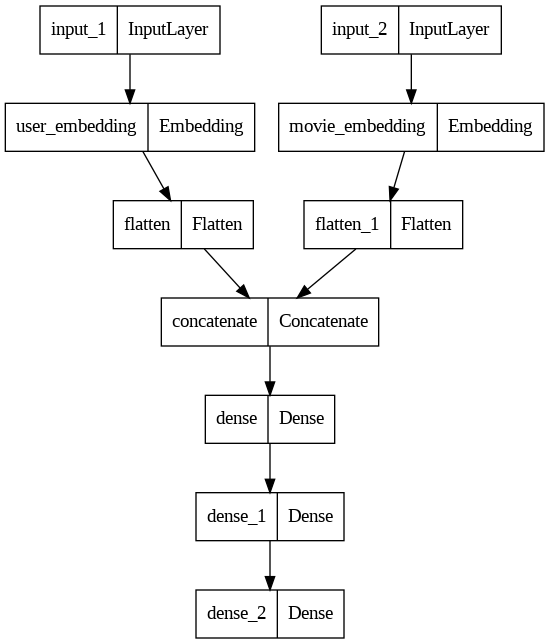

In [15]:
tf.keras.utils.plot_model(model)

In [25]:
train.movieId.head(10)

80568    4285
50582    5629
8344      134
99603      66
71701    1172
95405    5162
13938    3913
52544     147
64437    2289
22977    1682
Name: movieId, dtype: int64

In [13]:
# 모델 학습
history = model.fit(x=[train.userId, train.movieId], 
                    y=train.rating,
                    epochs=10, verbose=2, 
                    validation_data=([validation.userId, validation.movieId], validation.rating))

Epoch 1/10
2521/2521 - 18s - loss: 0.4086 - accuracy: 0.8253 - auc: 0.7690 - val_loss: 0.3957 - val_accuracy: 0.8296 - val_auc: 0.7967 - 18s/epoch - 7ms/step
Epoch 2/10
2521/2521 - 12s - loss: 0.3503 - accuracy: 0.8500 - auc: 0.8447 - val_loss: 0.3996 - val_accuracy: 0.8315 - val_auc: 0.7991 - 12s/epoch - 5ms/step
Epoch 3/10
2521/2521 - 15s - loss: 0.3215 - accuracy: 0.8649 - auc: 0.8709 - val_loss: 0.4034 - val_accuracy: 0.8308 - val_auc: 0.7946 - 15s/epoch - 6ms/step
Epoch 4/10
2521/2521 - 17s - loss: 0.2970 - accuracy: 0.8745 - auc: 0.8917 - val_loss: 0.4288 - val_accuracy: 0.8229 - val_auc: 0.7913 - 17s/epoch - 7ms/step
Epoch 5/10
2521/2521 - 9s - loss: 0.2711 - accuracy: 0.8864 - auc: 0.9109 - val_loss: 0.4593 - val_accuracy: 0.8173 - val_auc: 0.7760 - 9s/epoch - 3ms/step
Epoch 6/10
2521/2521 - 11s - loss: 0.2446 - accuracy: 0.8972 - auc: 0.9285 - val_loss: 0.4972 - val_accuracy: 0.8062 - val_auc: 0.7722 - 11s/epoch - 4ms/step
Epoch 7/10
2521/2521 - 10s - loss: 0.2157 - accuracy: 

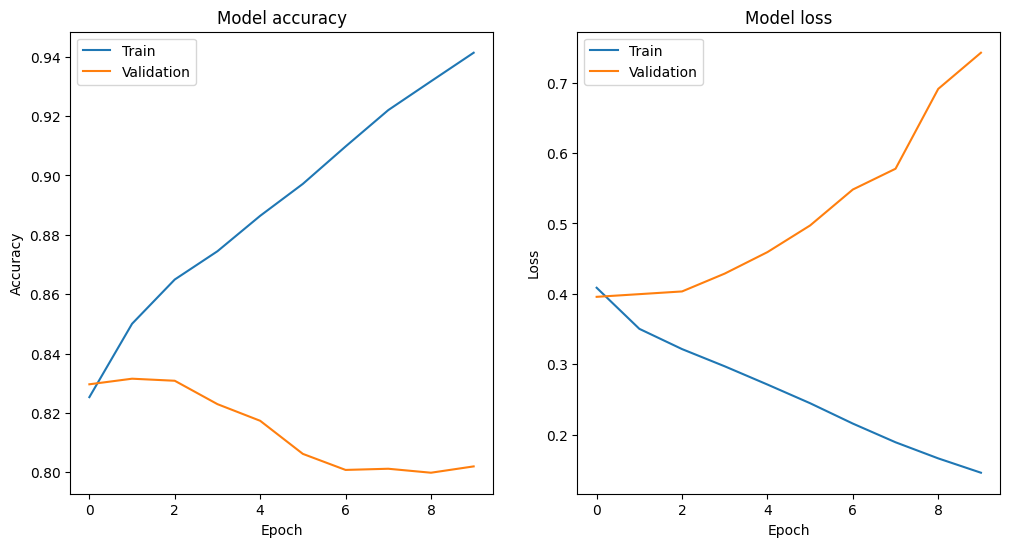

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [16]:
# 유저/아이템 입력 레이어
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# 임베딩 차원
n_latent_factors = 20

# 임베딩 레이어 정의
user_embedding = Embedding(num_unique_users, n_latent_factors, name='user_embedding')(user_input)
movie_embedding = Embedding(num_unique_movies, n_latent_factors, name='movie_embedding')(movie_input)

# 임베딩 flatten
user_vector = Flatten()(user_embedding)
movie_vector = Flatten()(movie_embedding)

# 유저 및 영화 임베딩 벡터 컨캣
concat = Concatenate()([user_vector, movie_vector])

In [17]:
# MLP 생성하는 함수 -> 원하는 형태로 블록처럼 쌓을 수 있음
def create_mlp(hidden_layers, output):
    for i in range(len(hidden_layers)):
        if i == 0:
            hidden = Dense(hidden_layers[i], activation='relu')(output)
        else:
            hidden = Dense(hidden_layers[i], activation='relu')(hidden)
    output = Dense(1, activation='sigmoid')(hidden)  # 이진 출력은 시그모이드 활성화로
    return output

In [18]:
# create_mlp 함수를 사용하여 MLP 모델 생성
output = create_mlp([64, 64, 32, 32], concat)

In [19]:
# 최종 모델
model = Model(inputs=[user_input, movie_input], outputs=output)

In [20]:
# 모델을 컴파일 -> auc 함수로 평가
auc = tf.keras.metrics.AUC()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auc])

In [21]:
# 모델 요약
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 20)        12220       ['input_3[0][0]']                
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 20)        194500      ['input_4[0][0]']                
                                                                                            

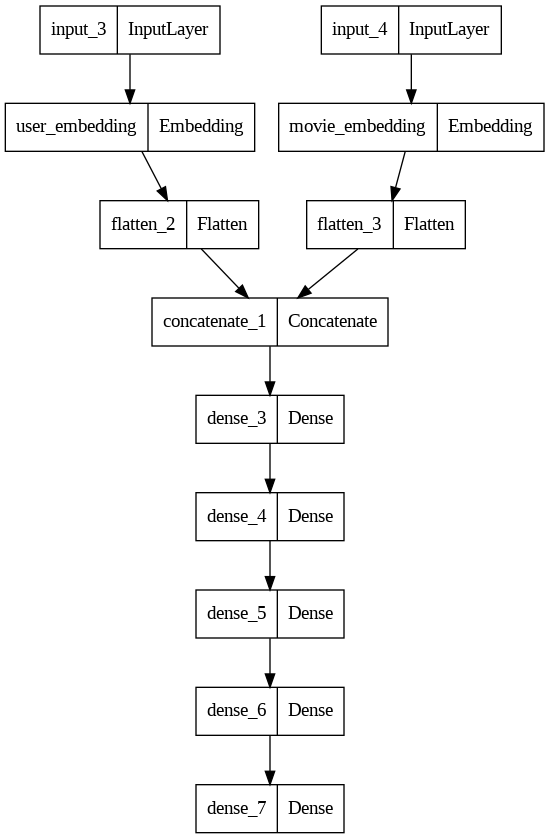

In [22]:
tf.keras.utils.plot_model(model)

In [23]:
# 모델 학습
history = model.fit(x=[train.userId, train.movieId], 
                    y=train.rating,
                    epochs=10, verbose=2, 
                    validation_data=([validation.userId, validation.movieId], validation.rating))

Epoch 1/10
2521/2521 - 12s - loss: 0.4089 - accuracy: 0.8263 - auc_1: 0.7682 - val_loss: 0.3929 - val_accuracy: 0.8293 - val_auc_1: 0.8001 - 12s/epoch - 5ms/step
Epoch 2/10
2521/2521 - 11s - loss: 0.3517 - accuracy: 0.8495 - auc_1: 0.8435 - val_loss: 0.3908 - val_accuracy: 0.8300 - val_auc_1: 0.8007 - 11s/epoch - 4ms/step
Epoch 3/10
2521/2521 - 9s - loss: 0.3211 - accuracy: 0.8647 - auc_1: 0.8714 - val_loss: 0.4019 - val_accuracy: 0.8289 - val_auc_1: 0.7959 - 9s/epoch - 4ms/step
Epoch 4/10
2521/2521 - 11s - loss: 0.2921 - accuracy: 0.8775 - auc_1: 0.8952 - val_loss: 0.4223 - val_accuracy: 0.8278 - val_auc_1: 0.7850 - 11s/epoch - 4ms/step
Epoch 5/10
2521/2521 - 10s - loss: 0.2637 - accuracy: 0.8898 - auc_1: 0.9154 - val_loss: 0.4594 - val_accuracy: 0.8205 - val_auc_1: 0.7799 - 10s/epoch - 4ms/step
Epoch 6/10
2521/2521 - 12s - loss: 0.2349 - accuracy: 0.9015 - auc_1: 0.9332 - val_loss: 0.4853 - val_accuracy: 0.8167 - val_auc_1: 0.7708 - 12s/epoch - 5ms/step
Epoch 7/10
2521/2521 - 9s - lo

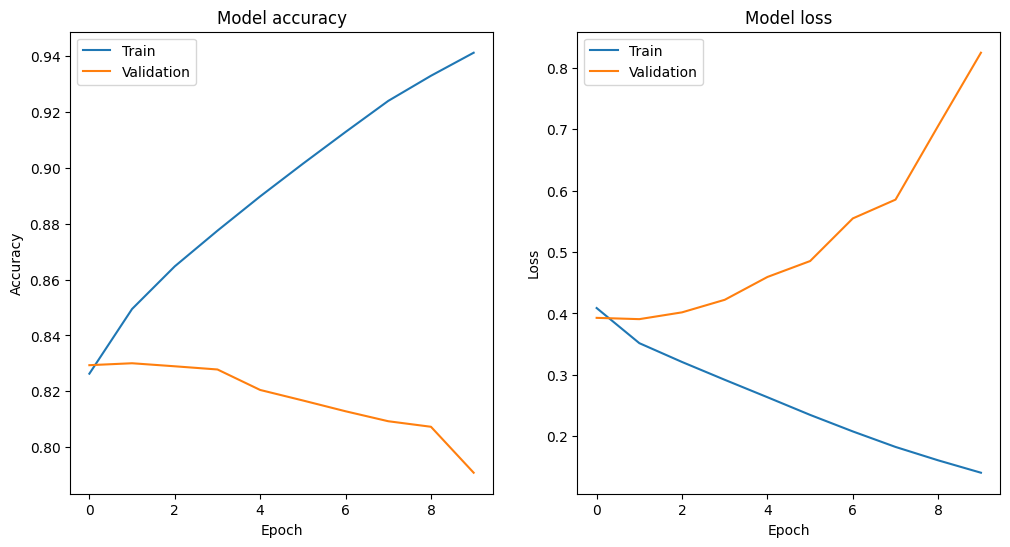

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# 과적합 해소

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [ ]:
# 유저/아이템 입력 레이어
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# 임베딩 차원
n_latent_factors = 20

# 임베딩 레이어 정의
user_embedding = Embedding(num_unique_users, n_latent_factors, name='user_embedding')(user_input)
movie_embedding = Embedding(num_unique_movies, n_latent_factors, name='movie_embedding')(movie_input)

# 임베딩 flatten
user_vector = Flatten()(user_embedding)
movie_vector = Flatten()(movie_embedding)

# 유저 및 영화 임베딩 벡터 컨캣
concat = Concatenate()([user_vector, movie_vector])

In [ ]:
def create_mlp(hidden_layers, output):
    for i in range(len(hidden_layers)):
        if i == 0:
            hidden = Dense(hidden_layers[i], activation='relu', kernel_regularizer=l2(0.001))(output)
        else:
            hidden = Dense(hidden_layers[i], activation='relu', kernel_regularizer=l2(0.001))(hidden)
        hidden = Dropout(0.2)(hidden)

    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(hidden)  
    return output

In [ ]:
# create_mlp 함수를 사용하여 MLP 모델 생성
output = create_mlp([128, 128], concat)

In [ ]:
# 최종 모델
model = Model(inputs=[user_input, movie_input], outputs=output)

In [ ]:
# 모델을 컴파일 -> auc 함수로 평가
auc = tf.keras.metrics.AUC()

learning_rate = 0.005 

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy', auc])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x=[train.userId, train.movieId], 
                    y=train.rating,
                    epochs=10, verbose=2, 
                    validation_data=([validation.userId, validation.movieId], validation.rating),
                    callbacks=[early_stopping])

Epoch 1/10
2521/2521 - 3s - loss: 0.4292 - accuracy: 0.8164 - auc_12: 0.7585 - val_loss: 0.4106 - val_accuracy: 0.8275 - val_auc_12: 0.7926 - 3s/epoch - 1ms/step
Epoch 2/10
2521/2521 - 2s - loss: 0.3819 - accuracy: 0.8416 - auc_12: 0.8245 - val_loss: 0.4168 - val_accuracy: 0.8262 - val_auc_12: 0.7906 - 2s/epoch - 968us/step
Epoch 3/10
2521/2521 - 2s - loss: 0.3624 - accuracy: 0.8522 - auc_12: 0.8462 - val_loss: 0.4119 - val_accuracy: 0.8307 - val_auc_12: 0.7924 - 2s/epoch - 965us/step
Epoch 4/10
2521/2521 - 2s - loss: 0.3501 - accuracy: 0.8583 - auc_12: 0.8583 - val_loss: 0.4165 - val_accuracy: 0.8223 - val_auc_12: 0.7884 - 2s/epoch - 968us/step
Epoch 5/10
2521/2521 - 2s - loss: 0.3415 - accuracy: 0.8637 - auc_12: 0.8667 - val_loss: 0.4386 - val_accuracy: 0.8270 - val_auc_12: 0.7872 - 2s/epoch - 970us/step
Epoch 6/10
2521/2521 - 2s - loss: 0.3328 - accuracy: 0.8676 - auc_12: 0.8743 - val_loss: 0.4338 - val_accuracy: 0.8233 - val_auc_12: 0.7811 - 2s/epoch - 969us/step


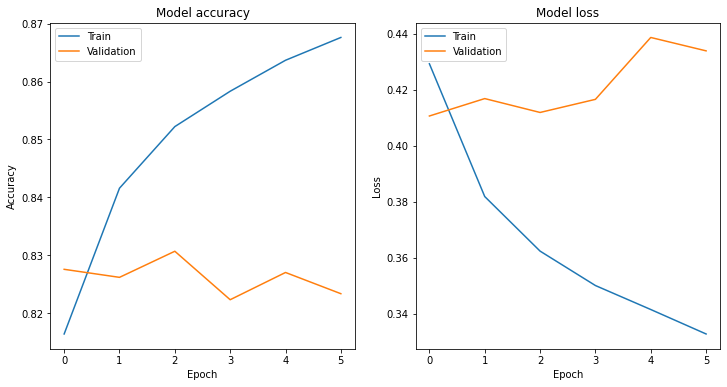

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
pd.DataFrame(history.history)

,loss,accuracy,auc_12,val_loss,val_accuracy,val_auc_12
0,0.429231,0.816371,0.758546,0.410599,0.827549,0.792573
1,0.381857,0.841573,0.824507,0.416813,0.826160,0.790564
2,0.362388,0.852221,0.846157,0.411860,0.830672,0.792419
3,0.350106,0.858333,0.858311,0.416539,0.822293,0.788406
4,0.341549,0.863688,0.866699,0.438621,0.827003,0.787214
5,0.332819,0.867630,0.874323,0.433844,0.823334,0.781085
